In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
from math import sqrt
from collections import Counter
from typing import List, Dict, Tuple, Optional

In [64]:
from workman_layout import keys, characters #Modify this line to choose the layout. A new layout is assumed to provided similarly

In [65]:
def calculate_key_frequencies(text: str) -> Dict:
    
    """Returns a dictionary of keys and frequencies
    Parameters:
    text(str): The text string for which the frequencies are counted.
    Returns:
    Dict: A dictionary holding all the unique key presses as keys and
    frequency of presses as values of the keys
    """
    
    key_frequency = Counter() #Initialises a Counter object which can be the dictionary
    
    for character in text:
        if character in characters:
            key_sequence = characters[character] #This handles the cases such
            # as special characters which have two keys pressed
            for key in key_sequence:
                key_frequency[key] += 1
    return key_frequency

In [66]:
def get_shift_char(key: str) -> Tuple[str, str]:
    
    """Returns the decomposition of the key.
    
    Parameters:
    key(str): The key that needs to be decomposed
    
    Returns:
    Tuple(str, str): The key pressed to print the character, and the corresponding
    shift key if pressed.
    
    For instance, # would return 3, Shift_R because those two keys are pressed
    to type the character #
    """
    
    shift_char = None
    normal_char = None
    
    #Iterate over the array of characters to see if a shift key is pressed
    for char, sequence in characters.items():
        if len(sequence) == 1 and sequence[0] == key:
            normal_char = char
        elif len(sequence) > 1 and sequence[1] == key:#Shift pressed
            shift_char = char
    return normal_char, shift_char

In [67]:
def dist(pos1: Tuple, pos2: Tuple) -> float:
    """Returns the Euclidean distance between keys.
    
    Parameters:
    pos1, pos2: The position tuples indicating the (x, y) coordinates.
    
    Returns:
    float: The Euclidean distance between the two points.
    
    """
    return sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

In [68]:
def calc_distance(c: str, keys: Dict, characters: Dict) -> float:
    """
    Evaluates the travel distance to press this key from the home row.
    
    Parameters:
    c(str): The key whose travel distance is computed.
    
    Returns:
    float: The distance moved by the fingers to make the stroke.
    """
    
    key_sequence = characters[c] #Checks if more than one key is pressed for this key
    c1 = key_sequence[-1] #Takes the last key as the main key
    
    if c1 == 'Space': #Handling Space separately
        return dist(keys[c1]['pos'], keys[keys[c1]['start']]['pos'])
    
    elif len(characters[c]) == 1:
        return dist(keys[c]['pos'], keys[keys[c]['start']]['pos'])
    
    else: #Computing distance as sum when Shift is also pressed for special keys
        return dist(keys[characters[c][0]]['pos'], keys[keys[characters[c][0]]['start']]['pos']) + dist(keys[characters[c][1]]['pos'], keys[keys[characters[c][1]]['start']]['pos']) 

In [69]:
def create_heatmap_data(key_frequencies: Dict[str, float], resolution: int = 1000) -> np.ndarray:
    """
    Generates heatmap data based on the frequency of key presses and the positions of keys.
    
    Parameters:
    key_frequencies (Dict[str, float]): A dictionary where keys are characters and values are their frequencies.
    resolution (int): The resolution of the heatmap grid, defining the number of points per dimension.
    
    Returns:
    np.ndarray: A 2D numpy array representing the heatmap data, where the value at each point corresponds
    to the intensity of key presses at that location.
    """
    
    #Grid of values that spans the keyboard to be plot. Values chosen to fit the QWERTY keyboard
    #and any other standard keyboard with the same layout but different key positions
    
    x = np.linspace(-1, 15, resolution)
    y = np.linspace(-1, 6, resolution)
    xx, yy = np.meshgrid(x, y)
    
    #Heatmap of zeros to be filled later
    heatmap = np.zeros((resolution, resolution))
    
    #Evaluating heatmap intensity for the key and its frequency
    for key, freq in key_frequencies.items():
        if key in keys:
            pos = keys[key]['pos']
            #Using gaussian blend to make a smooth heatmap
            heatmap += freq * np.exp(-((xx - pos[0])**2 + (yy - pos[1])**2) / 0.5)
    
    #Further smoothening. Increase sigma for more smoothening
    return gaussian_filter(heatmap, sigma=1)


In [70]:
def draw_keyboard(text: Optional[str] = None) -> None:
    """
    Draws a visual representation of the keyboard along with a heatmap indicating key press frequencies.
    
    Parameters:
    text (Optional[str]): The input text to analyze key frequencies.
    If not provided, the empty keyboard layout is shown.
    
    Returns:
    None: Displays the keyboard with a heatmap overlaid.
    """
    
    fig, ax = plt.subplots(figsize=(20, 8)) #Setting up the plot to be made
    
    if text:
        key_frequencies = calculate_key_frequencies(text)
        max_freq = max(key_frequencies.values()) if key_frequencies else 1
    else:
        key_frequencies = {}
        max_freq = 1
    
    heatmap_data = create_heatmap_data(key_frequencies) #Initialise heatmap using the function defined before
    
    #Creating a custom color map(rainbow) with zero replaced with white for a plain background keyboard
    rainbow = plt.get_cmap('rainbow')
    colors = [1, 1, 1] #Values for white
    num_colors = 256  #Resolution of gradient. Increase when string is larger to look better
    new_colors = [colors] + [rainbow(i / (num_colors - 1)) for i in range(num_colors)]  
    cmap = LinearSegmentedColormap.from_list('custom_rainbow', new_colors, N=num_colors)
    
    #Plotting the heatmap
    shift = 0.5  #Moving the heatmap so that it is centred over the keys
    #Change shift depending on the keyboard layout and key sizes
    
    img = ax.imshow(heatmap_data, extent=[0 + shift - 1, 15 + shift, 0 + shift - 1, 6 + shift],
                    origin='lower', cmap=cmap, alpha=1)
    
    cbar = plt.colorbar(img, ax=ax)
    cbar.set_label('Frequency of key strokes', rotation=270, labelpad=20)
    
    #Using special sizes for the special keys for better aesthetics
    special_keys = ['Shift_L', 'Shift_R', 'Ctrl_L', 'Ctrl_R', 'Alt_L', 'Alt_R', 'Space']
    key_sizes: Dict[str, Tuple[float, float]] = {}
    
    for key, info in keys.items():
        if key in special_keys:
            if key.startswith('Shift'):
                key_sizes[key] = (2, 1)
            elif key.startswith('Ctrl') or key.startswith('Alt'):
                key_sizes[key] = (1.5, 1)
            elif key == 'Space':
                key_sizes[key] = (6, 1)
        else:
            key_sizes[key] = (1, 1)
    
    for key, info in keys.items(): #Plot the key one by one on the plot
        draw_key(ax, key, info, key_sizes[key])
    
    #Viewing limits, chosen for best view
    ax.set_xlim(-1, 15 + 1)
    ax.set_ylim(-1, 6)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.title("Keyboard Heatmap", fontsize=16)
    plt.show()


In [71]:
def draw_key(ax, key: str, info: Dict[str, Tuple[float, float]], key_size: Tuple[float, float]) -> None:
    """
    Draws a single key on the keyboard plot.
    
    Parameters:
    ax (matplotlib.axes.Axes): The Matplotlib axis object where the key will be drawn.
    key (str): The label of the key
    info (Dict[str, Tuple[float, float]]): A dictionary containing information about the key,
    specifically the position of the key on the keyboard.
    key_size (Tuple[float, float]): The size (width, height) of the key.
    
    Returns:
    None: The function simply draws on the axes given as inputs.
    """
    
    x, y = info['pos'] #Finding position of the key
    key_width, key_height = key_size
    
    #Adjusting my key spacing and position for best viewability
    key_spacing = 0.1
    adjusted_x = x
    adjusted_y = y
    
    #Using patches to make the outline of the keys on the keyboard
    rect = patches.FancyBboxPatch(
        (adjusted_x, adjusted_y), 
        key_width - key_spacing, 
        key_height - key_spacing,
        boxstyle="round,pad=0.05", 
        linewidth=1.5, 
        edgecolor='black', 
        facecolor='none'
    )
    ax.add_patch(rect)
    
    #Find the base key and the shifts pressed for the key
    normal_char, shift_char = get_shift_char(key)
    
    #Display characters on the key
    if normal_char and shift_char and not normal_char.isalpha():
        ax.text(adjusted_x + (key_width - key_spacing) * 0.3, 
                adjusted_y + (key_height - key_spacing) * 0.7, 
                shift_char, ha='center', va='center', fontsize=14, color='black')
        ax.text(adjusted_x + (key_width - key_spacing) * 0.7, 
                adjusted_y + (key_height - key_spacing) * 0.3, 
                normal_char, ha='center', va='center', fontsize=18, fontweight='bold', color='black')
    else:
        #Display only the base key for no special character support
        ax.text(adjusted_x + (key_width - key_spacing) / 2, 
                adjusted_y + (key_height - key_spacing) / 2, 
                key, ha='center', va='center', fontsize=18, fontweight='bold', color='black')

Enter the text for heatmap analysis (or press Enter for default keyboard layout):  Wikipedia[c] is a free content online encyclopedia written and maintained by a community of volunteers, known as Wikipedians, through open collaboration and the wiki software MediaWiki. Wikipedia is the largest and most-read reference work in history,[3][4] and is consistently ranked among the ten most visited websites; as of August 2024, it was ranked fourth by Semrush,[5] and seventh by Similarweb.[6] Founded by Jimmy Wales and Larry Sanger on January 15, 2001, Wikipedia has been hosted since 2003 by the Wikimedia Foundation, an American nonprofit organization funded mainly by donations from readers.


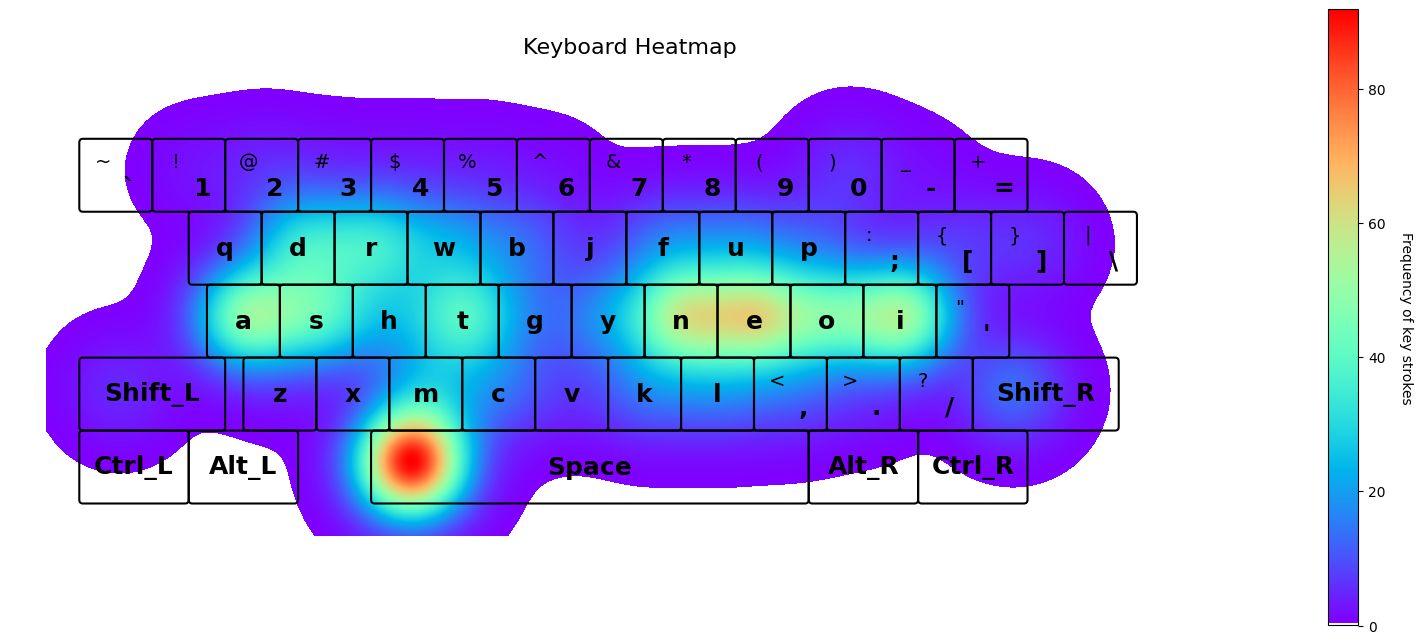

The net keyboard travel length is: 813.34


In [72]:
def main():
    """
    Performs the analysis and plotting by calling the respective functions. Provide inputs here)
    """
    
    input_text = input("Enter the text for heatmap analysis (or press Enter for default keyboard layout): ")
    
    draw_keyboard(input_text if input_text else None)
    
    travel_len = 0
    for character in input_text.rstrip():
        travel_len += calc_distance(character, keys, characters)
    
    print("The net keyboard travel length is:", f"{travel_len:.2f}")

if __name__ == "__main__":
    main()